In [16]:
import re
import random
import pandas as pd
import hashlib

In [ ]:
with open("certcards2.txt", mode="r", encoding="utf8") as f:
    all_cards = f.read()

card_split_pattern = r"\n\n\n\d+\n"
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r"(.+?)\n([\s\S]+)", re.DOTALL)
cards = [
    (match.group(1), match.group(2))
    for cstring in all_cards
    if (match := re.search(card_pattern, cstring))
]

# removing the cards that have no content and trimming
cards = [
    (subject, stripped_content)
    for subject, content in cards
    if len(stripped_content := content.strip()) > 5
]


def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode("utf-8")).hexdigest()


def remake_card_document(
    existing_cards: pd.DataFrame, filename: str = "certcards2.txt"
):
    with open(filename, mode="w", encoding="utf8") as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write("\n" * 6)
            f.write(str(i) + "\n")
            f.write(row["head"] + "\n")
            f.write(row["body"])
            i += 1
    print(f"Cards found: {existing_cards.shape[0]}")
    print(f"Total card age: {abs(existing_cards['age'].sum()):.2f}")


existing_cards = pd.DataFrame(cards, columns=["head", "body"])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards["hash"] = existing_cards["body"].apply(hash_string_md5)

card_ages = pd.read_json("card_ages.json")
card_ages = card_ages.drop_duplicates(subset=["hash"], keep="first")

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[["hash", "age"]],
    left_on="hash",
    right_on="hash",
    how="left",
)


cards_to_age["head"] = cards_to_age["head"].str.strip()

# remove headers I don't want anymore
undesired_headers = ["CCH Axcess"]
cards_to_age = cards_to_age.loc[~cards_to_age["head"].isin(undesired_headers), :].copy()

cards_to_age["age"] = cards_to_age["age"].fillna(0)

age_factor = 1.01
cards_to_age["age"] = cards_to_age["age"] * age_factor

cards_to_age["age"] = cards_to_age["age"] + [
    random.expovariate(0.5) for _ in cards_to_age.index
]



mean = cards_to_age["age"].mean()
threshold = .005+(mean/1000)
shuffle_role = random.random()
print(f"{shuffle_role=:.6f}; {threshold=:.6f}")
if shuffle_role < threshold:
    cards_to_age["age"] = cards_to_age["age"] * [
        random.expovariate(1.3) for _ in cards_to_age.index
    ]

# Adding priority age growth to cards for upcoming certifications 
priority_headers = [
    "Django", 
    "Python + Oauth2.0",
    "Microsoft Purview"
    ]
priority_cards_mask = cards_to_age["head"].isin(priority_headers)
cards_to_age.loc[priority_cards_mask, "age"] = (
    cards_to_age.loc[priority_cards_mask, "age"] * 1.0718
)

cards_to_age = cards_to_age.drop_duplicates(subset=["hash"], keep="first")

cards_to_age["subject_mean_age"] = cards_to_age.groupby("head")["age"].transform("mean")
cards_to_age["subject_highest_age"] = cards_to_age.groupby("head")["age"].transform(
    "max"
)
cards_to_age["subject_age_sum"] = cards_to_age.groupby("head")["age"].transform("sum")
cards_to_age["head_random_roll"] = cards_to_age.groupby("head")["head"].transform(
    lambda x: random.random()
)
cards_to_age["head_count"] = cards_to_age.groupby("head")["head"].transform("count")


cards_to_age.sort_values("hash")[["age", "head", "hash"]].to_json(
    "card_ages.json", indent=2
)

existing_cards = cards_to_age

shuffle_role=0.009780; threshold=0.057102


In [18]:
ave_order = ('age', 'mean')
sum_order = ('age', 'sum')

stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(ave_order)
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
ODBC,38.777509,2.423594,7.433581,16
Ansible,119.879354,2.996984,33.430983,40
"Everything is Tuberculosis, Green",400.233601,17.401461,97.878162,23
Ubuntu,534.288686,20.549565,49.418363,26
Network Terms,318.274354,21.218290,48.625653,15
Exchange Online and Defender,846.394463,21.702422,97.955010,39
Power BI,71.711358,23.903786,40.642487,3
SSH + SCP,725.413676,25.014265,72.043820,29
"The Mines of the Behemoth, Shea",1279.971660,26.121871,226.403933,49
eDiscovery,1461.544860,27.065646,306.835184,54


# Histogram

sum of ages: ~30656.80


<Axes: >

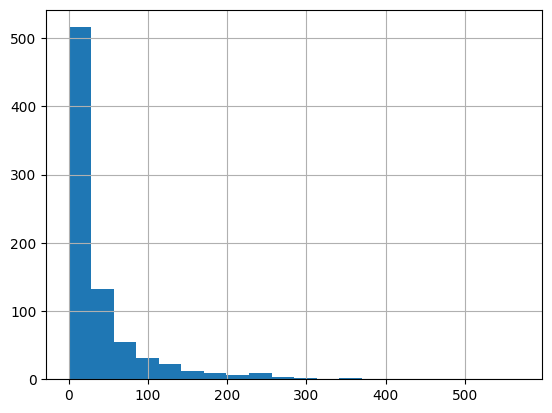

In [19]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

sum of ages: ~30656.80


<Axes: >

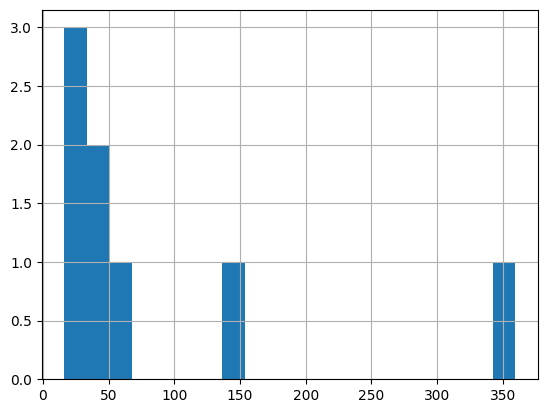

In [20]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards[existing_cards['head']=='Python + Oauth2.0']['age'].hist(bins=20)

# Completely Random Shuffle

In [21]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [22]:
existing_cards = existing_cards.sort_values('age', ascending=False)
remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
existing_cards.head(10)

Cards found: 802
Total card age: 30656.80


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count
0,Microsoft Purview,You can apply just one sensitivity label to an...,50f85d7bb8f9e04601a53f72976eeb45,568.910892,70.565663,568.910892,2681.495203,0.055001,38
62,Docker,Seccomp and AppArmor\nDocker applies default s...,6df59894a7bb187495fe45518d0b3d25,421.871945,57.062056,421.871945,1768.923742,0.800624,31
46,Python + Oauth2.0,urllib.parse.unquote()\n\nDecodes percent-enco...,a3712ee8797e5a427a1ac8b184a7402c,359.295429,87.303423,359.295429,698.427385,0.155726,8
2,Microsoft Purview,Microsoft Purview includes:\nSensitive informa...,3c753353c6695bdcff7b2121467b00ed,343.808816,70.565663,568.910892,2681.495203,0.055001,38
105,eDiscovery,You're troubleshooting a hold and see an error...,df3cdec73c3bdb9fa3fc68f2019028ff,306.835184,27.065646,306.835184,1461.544860,0.419681,54
187,Node.js and Vite,Working Directory\nThe current folder your ter...,bb6092d07f0ff7b7ff31e18396c03738,295.226246,68.517634,295.226246,2261.081928,0.544579,33
209,Python,Read a file in chunks by defining a generator ...,ea2daaaf6042804e2a0b5e287c803774,277.052569,36.603621,277.052569,1866.784646,0.729510,51
197,Azure Files Documentation,"For Azure Files, the Secure transfer required ...",7b7af66f22b309a8d07b437a6e6bd573,276.457097,52.789763,276.457097,2111.590520,0.055222,40
95,Windows PATH Variable,set\nA CMD command that modifies environment v...,a12527f9c18a5fa3a4cefe8381615b76,259.249319,50.075901,259.249319,1402.125223,0.805427,28
368,Windows PATH Variable,Backup\nSaving the current PATH before making ...,876918b806e208b5127a3bb00ca40b4d,255.291517,50.075901,259.249319,1402.125223,0.805427,28


# N-fold shuffle


## Age Sum

In [23]:
# n = 3
# m=existing_cards.shape[0]//100
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // m

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Age Mean

In [24]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)

## Age Max

In [25]:
# n = random.choice([2, 3, 3, 4, 4, 5])

# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# if existing_cards['age'].sum() > 0:
#     existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_highest_age', 'neg_age'], inplace=True)
# # existing_cards.sort_values(['age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Card Count

In [26]:
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()

# choices = ['floor', 'mod']
# option = random.choice(choices)
# if option == 'floor':
#     n=5
#     existing_cards['n_fold'] = existing_cards['count'] // n
#     print("floor dividing for n-fold")
# elif option == 'mod':
#     n=3
#     existing_cards['n_fold'] = existing_cards['count'] % n
#     print("modulo for n-fold")
# else: raise NotImplementedError


# if existing_cards['age'].sum() > 0:
#     # existing_cards['neg_subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
#     existing_cards['subject_highest_age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_count', 'subject_highest_age', 'neg_age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)


## Random

In [27]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [28]:
existing_cards.head(10)['age'].sum()

np.float64(3363.999012870435)

In [29]:
asc = existing_cards.age.sum() < 0

existing_cards.sort_values('age', ascending=asc).head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count
0,Microsoft Purview,You can apply just one sensitivity label to an...,50f85d7bb8f9e04601a53f72976eeb45,568.910892,70.565663,568.910892,2681.495203,0.055001,38
62,Docker,Seccomp and AppArmor\nDocker applies default s...,6df59894a7bb187495fe45518d0b3d25,421.871945,57.062056,421.871945,1768.923742,0.800624,31
46,Python + Oauth2.0,urllib.parse.unquote()\n\nDecodes percent-enco...,a3712ee8797e5a427a1ac8b184a7402c,359.295429,87.303423,359.295429,698.427385,0.155726,8
2,Microsoft Purview,Microsoft Purview includes:\nSensitive informa...,3c753353c6695bdcff7b2121467b00ed,343.808816,70.565663,568.910892,2681.495203,0.055001,38
105,eDiscovery,You're troubleshooting a hold and see an error...,df3cdec73c3bdb9fa3fc68f2019028ff,306.835184,27.065646,306.835184,1461.544860,0.419681,54
187,Node.js and Vite,Working Directory\nThe current folder your ter...,bb6092d07f0ff7b7ff31e18396c03738,295.226246,68.517634,295.226246,2261.081928,0.544579,33
209,Python,Read a file in chunks by defining a generator ...,ea2daaaf6042804e2a0b5e287c803774,277.052569,36.603621,277.052569,1866.784646,0.729510,51
197,Azure Files Documentation,"For Azure Files, the Secure transfer required ...",7b7af66f22b309a8d07b437a6e6bd573,276.457097,52.789763,276.457097,2111.590520,0.055222,40
95,Windows PATH Variable,set\nA CMD command that modifies environment v...,a12527f9c18a5fa3a4cefe8381615b76,259.249319,50.075901,259.249319,1402.125223,0.805427,28
368,Windows PATH Variable,Backup\nSaving the current PATH before making ...,876918b806e208b5127a3bb00ca40b4d,255.291517,50.075901,259.249319,1402.125223,0.805427,28


In [30]:
f"Average age: {abs(existing_cards['age'].mean()):.3f}"

'Average age: 38.225'